# `asyncmd.trajectory.ConditionalTrajectoryPropagator`

The `asyncmd.trajectory.ConditionalTrajectoryPropagator` can be used to easily propagate a trajectory (possibly in chunks of walltime) until any of the given conditions are fulfilled, i.e. it is one of the basic building blocks of a committor simulation and can also be used in many path sampling algorithms. Because propagating trajectories from some initial configuration until a state is reached is such a common condition (at least in the path sampling community) an alias for the `asyncmd.trajectory.ConditionalTrajectoryPropagator` is `asyncmd.trajectory.TrajectoryPropagatorUntilAnyState` . However, the most general view is that you give the `asyncmd.trajectory.ConditionalTrajectoryPropagator` a list of conditions (i.e. functions which act on trajectories and return `True` or `False` for every frame) and that the trajectory propagation is stopped as soon as any of these conditions are fulfilled.

In this notebook we will use the `asyncmd.trajectory.ConditionalTrajectoryPropagator` on the example of capped alanine dipeptide and propagate a trajectory from each of the conformations inside of a state until the other state is reached. We will see how to extract new initial configurations fo additional runs using the `asyncmd.trajectory.FrameExtractor`s and at the end we will also cut out a transition subtrajectory with the `TrajectoryConcatenator` class from the generated trajectories. We will run everything on the local machine (using `GmxEngine` and `PyTrajectoryFunctionWrapper`), but you could do exactly the same on a HPC cluster if you e.g. use the `SlurmGmxEngine` and `SlurmTrajectoryFunctionWrapper` classes instead.

**Required knowledge/recommended reading**: This notebook assumes some familiarity with the gromacs engine (see the notebooks in the `01_engines/gromacs` directory) and the TrajectoryFunctionWrappers (see notebooks `PyTrajectoryFunctionWrapper.ipynb` and/or `SlurmTrajectoryFunctionWrapper.ipynb`).

## Imports and some basic checks that everything is available

In [1]:
%%bash
# if using the module system to make gromacs and friends available:
# check that they are loaded!
#module list

In [2]:
%%bash
# unix only, check that gmx is available
which gmx

/usr/local/gromacs-2022.4/bin/gmx


In [3]:
%matplotlib inline

In [4]:
import os
import asyncio
import matplotlib.pyplot as plt
import numpy as np

In [5]:
import asyncmd
from asyncmd import gromacs as asyncgmx
from asyncmd import trajectory as asynctraj

Could not initialize SLURM cluster handling. If you are sure SLURM (sinfo/sacct/etc) is available try calling `asyncmd.config.set_slurm_settings()` with the appropriate arguments.


## Setup working directory
We will write the trajectory output to it.

In [6]:
workdir = "."

## Import the state functions and wrap them
These are the state functions also used in the `PyTrajectoryFunctionWrapper` and `SlurmTrajectoryFunctionWrapper` notebooks. Here we use a `PyTrajectoryFunctionWrapper` such that you can run this notebook on your local machine, if you want to run on a cluster with SLURM you should exchange it with its slurm-enabled sibling (and also use a `SlurmGmxEngine` instead of the `GmxEngine`).

In [7]:
cwd = os.path.abspath(os.getcwd())
# chdir to the resources folder so we can import the state functions
os.chdir("../resources/")

from ala_cv_funcs import C7_eq, alpha_R

os.chdir(cwd)

In [8]:
from asyncmd import trajectory as asynctraj

In [9]:
C7_eq_wrapped = asynctraj.PyTrajectoryFunctionWrapper(C7_eq)
# the optional call_kwargs argument can be used to specify additional keyword arguments
# [we pass skip=1 which does not do anything because it is the default value only to show that call_kwargs exists]
alpha_R_wrapped = asynctraj.PyTrajectoryFunctionWrapper(alpha_R, call_kwargs={"skip": 1})

### Load two different configurations as `asyncmd.Trajectory`
Each of them fullfills one of the two state functions.

In [10]:
# create an asyncmd.Trajectory of the initial configuration from the `GmxEngine.ipynb` notebook
conf_in_alphaR = asyncmd.Trajectory(trajectory_files="../resources/gromacs/capped_alanine_dipeptide/conf_in_alphaR.trr",
                                    structure_file="../resources/gromacs/capped_alanine_dipeptide/conf.gro",
                                    )
# create a second asyncmd.Trajectory of another configuration (in another state)
conf_in_C7eq = asyncmd.Trajectory(trajectory_files="../resources/gromacs/capped_alanine_dipeptide/conf_in_C7eq.trr",
                                  structure_file="../resources/gromacs/capped_alanine_dipeptide/conf.gro",
                                  )

### Apply the state functions to both configurations/trajectories simultaneously
Just to check that everything is as we expect.

In [11]:
states = [alpha_R_wrapped, C7_eq_wrapped]

states_for_conf_in_alphaR = await asyncio.gather(*(sf(conf_in_alphaR) for sf in states))
states_for_conf_in_C7eq = await asyncio.gather(*(sf(conf_in_C7eq) for sf in states))

print(f"States (alphaR, C7_eq) for conf_in_alphaR: {states_for_conf_in_alphaR}.")
print(f"States (alphaR, C7_eq) for other_conf: {states_for_conf_in_C7eq}.")

States (alphaR, C7_eq) for conf_in_alphaR: [array([ True]), array([False])].
States (alphaR, C7_eq) for other_conf: [array([False]), array([ True])].


## Load and potentially modify the parameter file (mdp file) for the molecular dynamics simulations

In [12]:
# Pcoupl = C-rescale needs gromacs version >= 2021
mdp = asyncgmx.MDP("../resources/gromacs/capped_alanine_dipeptide/md.mdp")
print(mdp["Pcoupl"])
# set nstxout-compressed, such that the engines will produce XTC trajectories
mdp["nstxout-compressed"] = 20
# and deactivate trr trajectory output
mdp["nstxout"] = mdp["nstvout"] = 0

C-rescale


In [13]:
# if your gmx version is >= 2021 you should comment the next line since C-rescale give the correct ensemble (and Berendsen does not!)
#mdp["Pcoupl"] = "Berendsen"

## Initialize the `ConditionalTrajectoryPropagator`s
Note that since here each of the conformations is already in one of the states, we will need to setup two separate propagators with one of the states each (for a propagator with both states both of the starting conformations already fulfill the stopping criterion "inside any of the states").

Here we also define the engine class to run the MD with and the engine call kwargs to use to initiate it.

In [14]:
# The walltime per trajectory part determines how often we check if the conditions are fulfilled,
# the "workflow" of the ConditionalTrajectoryPropagator is the following:
#     1.) propagate for walltime (computation possibly submitted via SLURM depending on the engine_cls used)
#     2.) check if any condition is fulfilled (also possibly submitted via SLURM depending on the condition (wrappers) used)
#     3.) If no condition is fulfilled go to 1.

walltime = 180 / (60 * 60)  # walltime is measured in hours, so this will be 180 s per part!

# define engine_kwargs once and use it for all propagators
engine_kwargs={"mdconfig": mdp,
               "gro_file": "../resources/gromacs/capped_alanine_dipeptide/conf.gro",
               "top_file": "../resources/gromacs/capped_alanine_dipeptide/topol_amber99sbildn.top",
# Since we are running locally, we will again use the `mdrun_extra_args` option to limit each engine to 2 threads
# (the box is so small that otherwise the domain decomposition might fail)
# depending on where you run and your gromacs version you might need to adapt this
               "mdrun_extra_args": "-nt 2",
               }

# propagator towards alphaR state (will be used for conf_in_C7eq)
propa_towards_alphaR = asynctraj.ConditionalTrajectoryPropagator(
                                               conditions=[alpha_R_wrapped], # list of state functions to terminate on
                                               engine_cls=asyncgmx.GmxEngine,
                                               engine_kwargs=engine_kwargs,
                                               walltime_per_part=walltime,
                                               # we could (and in production SHOULD) set an upper boundary for the total number of steps/frames
                                               # Note that max_steps and max_frames are redundant since max_frames = max_steps / nstout
                                               # and that max_steps takes precedence over max_frames
                                               #max_steps=1000000000,
                                               #max_frames=10000000,
                                                                    )

# propagator towards C7_eq state (for use with conf_in_alphaR)
propa_towards_C7_eq = asynctraj.ConditionalTrajectoryPropagator(
                                               conditions=[C7_eq_wrapped],
                                               engine_cls=asyncgmx.GmxEngine,
                                               engine_kwargs=engine_kwargs,
                                               walltime_per_part=walltime,
                                                                )

## Use the `propagate_and_concatenate()` method which directly concatenates the generated trajectory parts into one trajectory
This concatenated trajectory will go from the initial configuration until (including) the first frame on which any of the conditions was `True`, i.e. until the first state is reached.

We could however also use the `propagate()` method to get back a list of trajectory parts as soon as the first state is reached. If we would like we could then later concatenate the list of trajectory parts using the `concatenate()` method but maybe you rather want to use it as input to another function to e.g. construct a complete transition from two lists of trajectory parts going into different states and do the concatenation only once. In this case you might find the coroutine `asyncmd.trajectory.construct_TP_from_plus_and_minus_traj_segments` useful.

The bottom line is: This class is thought as building block for more complex algorithms and it is possible to call almost any of its functions independently. Have a look at the autocomplete, docstring, and the full documentation to find the methods that suit your goals/workflow the best.

In [15]:
# the `propagate_and_concatenate` method returns the tuple (traj_to_state, idx_of_first_state_reached)
# since both propagators only have one state we can directly discard that meaningless information (the idx is going to be zero in both cases)
# Using asyncio.gather as usual to do both MD runs in parallel
wdir_alphaR = os.path.join(workdir, "towards_alphaR")
os.mkdir(wdir_alphaR)
wdir_C7eq = os.path.join(workdir, "towards_C7eq")
os.mkdir(wdir_C7eq)
(traj_to_alphaR, _), (traj_to_C7eq, _) = await asyncio.gather(propa_towards_alphaR.propagate_and_concatenate(
                                                                                        starting_configuration=conf_in_C7eq,
                                                                                        workdir=wdir_alphaR,
                                                                                        deffnm="towards_alphaR",
                                                                                        tra_out=os.path.join(wdir_alphaR, "traj_to_alphaR.xtc")
                                                                                                             ),
                                                              propa_towards_C7_eq.propagate_and_concatenate(
                                                                                        starting_configuration=conf_in_alphaR,
                                                                                        workdir=wdir_C7eq,
                                                                                        deffnm="towards_C7_eq",
                                                                                        tra_out=os.path.join(wdir_C7eq, "traj_to_C7_eq.xtc")
                                                                                                            )
                                                              )

In [16]:
print(f"The trajectory towards alphaR has {len(traj_to_alphaR)} frames, the one towards C7_eq has {len(traj_to_C7eq)} frames.")

The trajectory towards alphaR has 3372 frames, the one towards C7_eq has 550 frames.


## More advanced use-cases

This section illustrates some of the more advanced use-cases such as continuing a propagation with changed conditions and also introduces some of the other asyncmd classes useful as building blocks like the `FrameExtractors`.

### Extract a frame not belonging to any state from the trajectory towards ${\alpha}_{R}$ and propagate from there
We will use the `asyncmd.trajectory.convert.NoModificationFrameExtractor` for that since we just want any configuration not in any of the states and do not care for its momenta. We can then use this extracted configuration for another round of conditional trajectory propagation, this time using two conditions at the same time.

Note that `asyncmd` includes a range of (hopefully) useful `FrameExtractors`, e.g. the `RandomVelocitiesFrameExtractor` to extract a frame and draw random Maxwell-Boltzmann velocities for it before writing it out or the `InvertedVelocitiesFrameExtractor` which is useful for two way shooting. In case you are interested have a look at the autocomplete of the `asyncmd.trajectory.convert` module or the full API documentation.

In [17]:
extractor = asynctraj.convert.NoModificationFrameExtractor()  # instantiate extractor
# find out which frames are in no state
frame_in_no_state = np.logical_not((await alpha_R_wrapped(traj_to_alphaR)) | (await C7_eq_wrapped(traj_to_alphaR)))

print(f"There are {np.sum(frame_in_no_state)} frames not in any state.")

There are 134 frames not in any state.


In [18]:
# these are the indices of the frames not in any state
# there should be a continuous strip of indices at the end, this is a complete transition from C7_eq to alphaR
np.where(frame_in_no_state)[0]

array([   4,    8,   10,   12,   13,   14,   15,   16,   27,   28,   29,
         30,   31,   32,   33,   34,   40,   41,   54,   55,   56,   57,
         58,   59,   70,   71,   72,   73,   74,   88,   89,  251,  298,
        341,  342,  343,  355,  356,  357,  358,  359,  360,  361,  396,
        397,  398,  481,  491,  492,  547, 1174, 1175, 1453, 1454, 1455,
       1456, 1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466,
       1475, 1478, 1479, 1480, 1568, 1569, 1571, 1572, 1573, 1734, 1750,
       1751, 1752, 1753, 1754, 1755, 1756, 1758, 1842, 1993, 1994, 1995,
       1996, 1997, 2230, 2231, 2273, 2274, 2275, 2276, 2277, 2278, 2279,
       2414, 2415, 2416, 2417, 2418, 2466, 2467, 2469, 2612, 2613, 2638,
       2642, 2696, 2697, 2698, 2769, 3047, 3335, 3336, 3337, 3338, 3339,
       3358, 3359, 3360, 3361, 3362, 3363, 3364, 3365, 3366, 3367, 3368,
       3369, 3370])

In [19]:
# create a subdirectory for the new conditionalpropagator
wdir_both_states = os.path.join(workdir, "towards_both_states")
os.mkdir(wdir_both_states)
# write out the structure
tp_conf = extractor.extract(outfile=os.path.join(wdir_both_states, "first_frame.trr"),
                            traj_in=traj_to_alphaR,
                            idx=np.where(frame_in_no_state)[0][-10], # (probably) takes a frame from the transition
                            )

In [20]:
tp_conf

Trajectory(trajectory_files=towards_both_states/first_frame.trr, structure_file=towards_alphaR/towards_alphaR.tpr)

In [21]:
# instantiate a propagator towards any of the two states, this will finish as soon as the first is reached
states = [alpha_R_wrapped, C7_eq_wrapped]
propa_towards_any_state = asynctraj.ConditionalTrajectoryPropagator(
                                                    conditions=states, # list of state functions to terminate on
                                                    engine_cls=asyncgmx.GmxEngine,
                                                    engine_kwargs=engine_kwargs,
                                                    walltime_per_part=0.01,  # walltime of 36 s per part
                                                                    )

In [22]:
# and propagate, this time we care what state is reached
traj_to_first_state, first_state_reached = await propa_towards_any_state.propagate_and_concatenate(
                                                                                        starting_configuration=tp_conf,
                                                                                        workdir=wdir_both_states,
                                                                                        deffnm="towards_any_state",
                                                                                        tra_out=os.path.join(wdir_both_states, "traj_to_state.xtc")
                                                                                                      )

### Extend the existing (and finished) propagation until the other state is reached.
When we do a continuation, the propagator will first check if any of the conditions are already met on the trial and if not extend the trajectory until one of the conditions is fulfilled (or `max_steps`/`max_frames` are reached). This means that you can use the propagator with refined conditions/state functions to continue an existing trial until the new/modified conditions are met.

(This example here is a bit boring as we will just wait for transition to the other state to occur).

In [23]:
conditions_not_reached = [s for i, s in enumerate(states) if i != first_state_reached]
propa_towards_other_state = asynctraj.ConditionalTrajectoryPropagator(
                                                    # take out the state we already reached from state functions list
                                                    conditions=conditions_not_reached,
                                                    engine_cls=asyncgmx.GmxEngine,
                                                    engine_kwargs=engine_kwargs,
                                                    walltime_per_part=0.05,  # walltime of 180 s per part
                                                                      )

#### Do a continuation of the previous run with modified conditions
Note that we need to use the same `workdir` and `deffnm` as before to make the continuation work.

In [24]:
# and propagate until the other state is reached
traj_to_second_state, second_state_reached = await propa_towards_other_state.propagate_and_concatenate(
                                                                                    starting_configuration=tp_conf,
                                                                                    # NOTE: need to use the same workdir as above,
                                                                                    #       otherwise we can not continue
                                                                                    workdir=wdir_both_states,
                                                                                    deffnm="towards_any_state",
                                                                                    tra_out=os.path.join(wdir_both_states, "traj_to_second_state.xtc"),
                                                                                    # NOTE: this is the important keyword here!
                                                                                    continuation=True,        
                                                                                                    )

In [25]:
print(f"We now created two trajectories starting from {tp_conf},")
print(f"the first one going to state {first_state_reached} (= {states[first_state_reached]}) is a subtrajectory of the second trajectory which goes from there to")
print(f"state {states.index(conditions_not_reached[0])} (= {conditions_not_reached[0]}).")
print(f"The first trajectory is {len(traj_to_first_state)} frames long, whereas the complete trajectory has {len(traj_to_second_state)} frames.")

We now created two trajectories starting from Trajectory(trajectory_files=towards_both_states/first_frame.trr, structure_file=towards_alphaR/towards_alphaR.tpr),
the first one going to state 1 (= PyTrajectoryFunctionWrapper(function=<function C7_eq at 0x7f7d3feaf880>, call_kwargs={})) is a subtrajectory of the second trajectory which goes from there to
state 0 (= PyTrajectoryFunctionWrapper(function=<function alpha_R at 0x7f7d3feaf600>, call_kwargs={'skip': 1})).
The first trajectory is 13 frames long, whereas the complete trajectory has 3554 frames.


#### Get the transition from the end of the complete trajectory
It contains a transition from the state reached in the first round to the other state.

In [26]:
frames_in_no_state = np.logical_not((await alpha_R_wrapped(traj_to_second_state)) | (await C7_eq_wrapped(traj_to_second_state)))
print(frames_in_no_state)

[ True  True  True ...  True  True False]


##### Use the `asyncmd.trajectory.convert.TrajectoryConcatenator` to write out the continuous transition
Here we just go 'backwards' trough the trajectory and take out the transition.

However the `TrajectoryConcatenator` can do much more: It can concatenate multiple trajectory parts (taking a list for the `trajs` argument) using only a subset of the frames (as specified by the `slices` argument to the `concatenate()` method) and it can automatically invert the momenta for segments that are taken with a negative stride (i.e. backwards in time). Furthermore it can optionally remove double frames (i.e. frames that have the same timestep information) while doing the concatenation.

In [27]:
traj_concat = asynctraj.convert.TrajectoryConcatenator()

tp_end_frame = None  # always the last one, since we stop as soon as the state is reached

tp_start_frame = len(frames_in_no_state) - 2  # the last is always False
while frames_in_no_state[tp_start_frame]:
    tp_start_frame -= 1

In [28]:
print(f"TP start frame = {tp_start_frame}")
print(f"TP end frame = {tp_end_frame} (== {len(traj_to_second_state)})")

TP start frame = 3444
TP end frame = None (== 3554)


In [29]:
constructed_tp = traj_concat.concatenate(trajs=[traj_to_second_state],
                                         slices=[(tp_start_frame, tp_end_frame, 1)],
                                         tra_out=os.path.join(workdir, "TP_300K_amber99sbildn.xtc"),
                                         overwrite=False)

In [30]:
constructed_tp

Trajectory(trajectory_files=TP_300K_amber99sbildn.xtc, structure_file=towards_both_states/towards_any_state.tpr)

In [31]:
len(constructed_tp)

110

##### Some basic sanity checks for the TP
There should be one frame in every state, i.e. the first frame will be in alphaR and the last frame in C7eq (or vice versa depending on which state we reached first in the trajectory generation).

In [32]:
await alpha_R_wrapped(constructed_tp)

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True])

In [33]:
await C7_eq_wrapped(constructed_tp)

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])

##### Plot the transition in the plane of $\phi$ and $\psi$
Mostly for the capped alanine dipeptide afficionados, who like to see the transition in the plane of the relevant degrees of freedom :)

In [34]:
cwd = os.path.abspath(os.getcwd())
# chdir to the resources folder so we can import the state functions
os.chdir("../resources/")

from ala_cv_funcs import descriptor_func_psi_phi

os.chdir(cwd)

In [35]:
psi_phi_wrapped = asynctraj.PyTrajectoryFunctionWrapper(descriptor_func_psi_phi)

In [36]:
vals = await psi_phi_wrapped(constructed_tp)

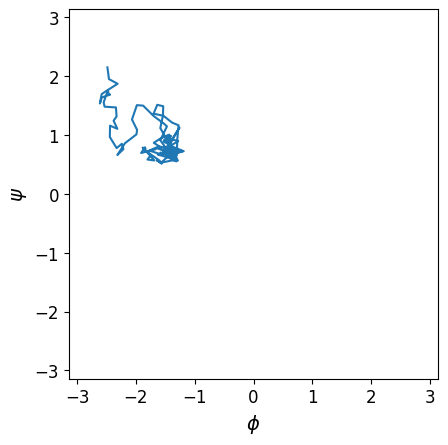

In [37]:
fig, axs = plt.subplots()

axs.plot(vals[:, 1], vals[:, 0])

axs.set_xlim(-np.pi, np.pi)
axs.set_ylim(-np.pi, np.pi)
axs.set_xlabel(r"$\phi$", size=14)
axs.set_ylabel(r"$\psi$", size=14)
axs.tick_params(labelsize=12)
axs.set_aspect("equal");